# Comparação de Estratégias de Seleção de Instâncias em Aprendizado Ativo

## Imports

In [1]:
import os

import pandas as pd
import numpy as np

## Reunindo Resultados para Comparação

In [2]:
RESULTS_DIR = '../../scripts/results/'

Por hora, seram analisados apenas as queries que utilizaram um determinado algoritmo (KNN) como aprendiz

## Definições

In [3]:
def gen_auc_df(file):
    auc_dict = dict()
    results = pd.read_csv(file)
    strategies = [c for c in results.columns if not 'choice' in c and not 'Unnamed' in c]
    
    for s in strategies:
        auc_dict[s] = [np.trapz(results[s][:i+1]) for i in range(len(results[s]))]
    auc_df = pd.DataFrame(auc_dict)
    
    return auc_df.sub(auc_df.random_meta_sampling, axis=0)

        

In [21]:
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

def display_graph(df,i, total, file ):
    df.plot.area(stacked=False, grid=True, figsize=(16, 6),
                     title=f'Ganho F1-macro X Query ({file if file else "Medio"}) [{i+1}/{total}]',
                     style=([None]*9 + ['*-']) )
    
def display_all_graphs(learner_result_files):

    for i, f in enumerate(learner_result_files):
        auc_df = gen_auc_df(f)

        display_graph(auc_df, i, len(learner_result_files), f)
        
        display(plt.gcf())
    
        input('Pressione Enter para continuar...')
    
        clear_output(wait=True)
        
        plt.close()

In [16]:
def summary_graph(learner_result_files):
    
    mean_dict, std_dict = dict(), dict()
    df_list = []
    for f in learner_result_files:
        df_list.append(gen_auc_df(f))

    strategies = df_list[0].columns

    for s in strategies:
        df = pd.concat([e[s] for e in  df_list], axis=1)
        mean_dict[s] = df.mean(axis=1)
        std_dict[s] = df.std(axis=1)

    styles = [None]*10
    styles[9] = '*-' # meta-sampling
    styles[0] = 'x-' # uncertainty
    styles[2] = 'D-' # margin

    pd.DataFrame(mean_dict).plot.area(stacked=False, grid=True, figsize=(16,8), title="Ganho Médio",
                                      style=styles)

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_heat_maps(result_files):
    df = pd.concat([pd.read_csv(f, index_col=0).filter(like='choice') for f in result_files], axis=1)
    value_to_int = {j:i for i, j in enumerate(pd.unique(df.values.ravel()))}
    cmap = sns.color_palette(n_colors=len(value_to_int))
    
    fig, axs = plt.subplots(1,2)
    fig.set_size_inches(40,10)
    plot_heat_map(df['meta_sampling_choice'], axs[0], 'Meta-sampling', result_files, value_to_int, cmap)
    plot_heat_map(df['perfect_sampling_choice'], axs[1], 'Perfect Meta-sampling', result_files, value_to_int, cmap)

    
def plot_heat_map(df, ax, title, result_files, value_to_int, cmap):

    new_columns = [os.path.basename(f) for f in result_files]
    new_df = df.replace(value_to_int)
    new_df.columns = new_columns
    
    
    sns.heatmap(new_df.T, cmap=cmap, linewidth=.1,ax=ax)
                                             
    
    colorbar = ax.collections[0].colorbar 
    n = len(value_to_int)
    r = colorbar.vmax - colorbar.vmin 
    colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
    colorbar.set_ticklabels(list(value_to_int.keys()))

    ax.set_title(title)

## KNN como Aprendiz

In [32]:
KNN = 'KNeighborsClassifier'

knn_results = !find $RESULTS_DIR -type f | grep $KNN

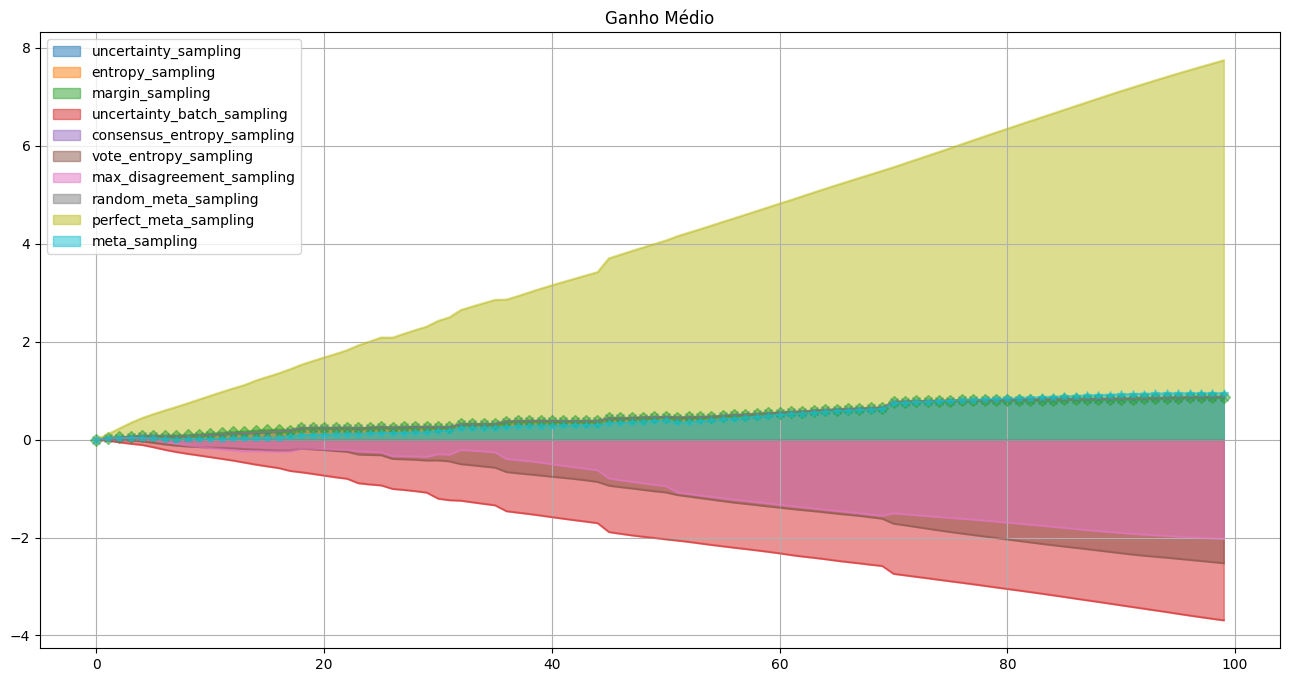

In [33]:
summary_graph(knn_results)

#### Gráficos Isolados

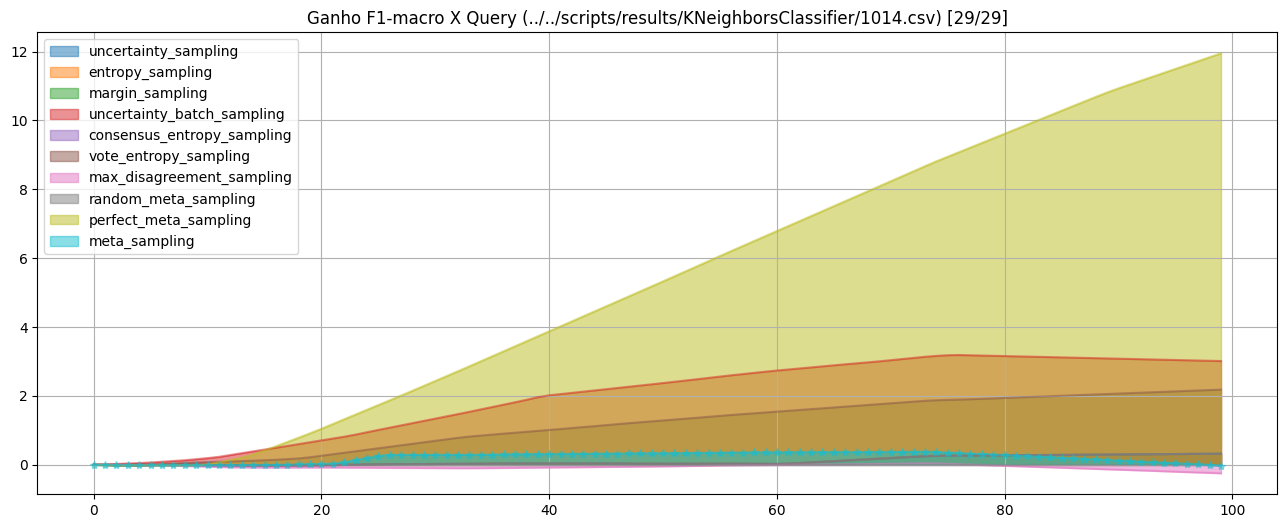

Pressione Enter para continuar... 


In [22]:
display_all_graphs(knn_results)

### Analisando Recomendações

In [24]:
! pip install -q seaborn

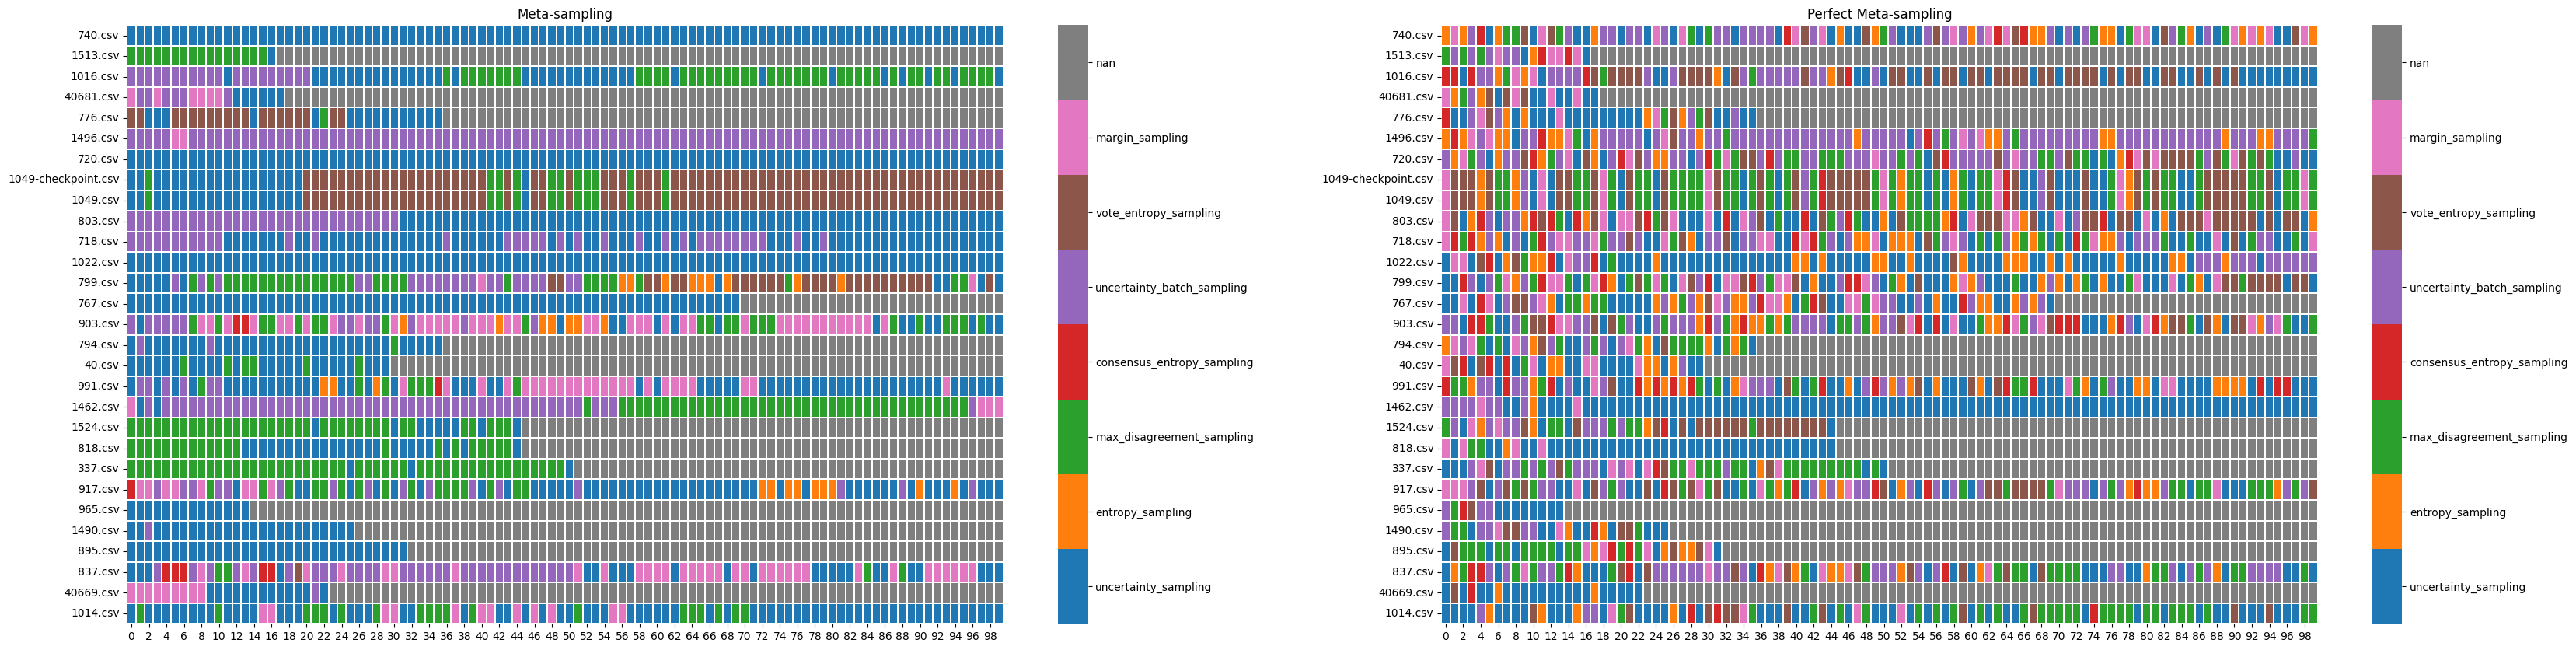

In [31]:
plot_heat_maps(knn_results)